# Project

## Importing modules

In [7]:
!pip install torchinfo --quiet

In [32]:
import os
import random
import gzip
import pickle
import zipfile
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
from torchinfo import summary
from matplotlib import pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Generic functions

The functions and classes here are taken from lab 5 with all the junk removed. They (should) work for any dataset.

In [9]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [10]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [11]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [12]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [13]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [14]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

## Loading MNIST as example

In [15]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://figshare.com/ndownloader/files/25635053"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL).content
        (PATH / FILENAME).open("wb").write(content)

In [16]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

('x_train.shape', (50000, 784))
('y_train.shape', (50000,))


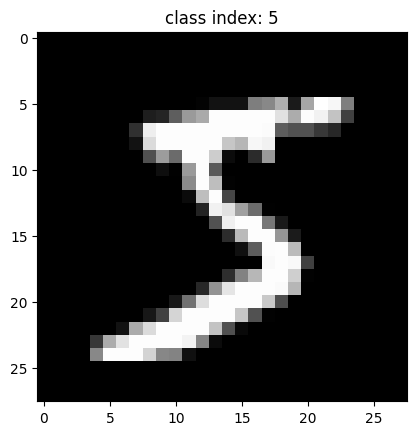

In [17]:
print(('x_train.shape',x_train.shape))
print(('y_train.shape',y_train.shape))

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
plt.title('class index: ' + str(y_train[0]));

### Split data

In [18]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

bs = 64  # batch size
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [19]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

### Model

Basic model with batchnormalization (as recommended in Training Convolutional Neural Networks - part 2)

In [26]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),  # batch normalization here
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),  # batch normalization here
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(10),  # batch normalization here
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

### Train

In [ ]:
model.to(dev)
lr = 0.01
epochs = 2
loss_func = F.cross_entropy
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 1.2265337846755981
1 0.6237620260238648


# Loading German traffic signs

In [22]:
# Path to your ZIP file in Google Drive
zip_file_path = '/content/gdrive/MyDrive/German-traffic-signs/archive.zip'

# Create a directory to extract the contents if it doesn't exist
extract_path = '/content/gtsrb'
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check the contents of the extracted folder
extracted_files = os.listdir(extract_path)
print(extracted_files)

['Test', 'train', 'Meta', 'meta', 'Meta.csv', 'test', 'Train.csv', 'Train', 'Test.csv']


**Define transformation and load into train, test and valdiadation set.**

Note that the test files the classes are hidden. So we just take train files and randomly split into train, test and validation set. Can be confirmed by running this code



```
# Check the contents of the train and test folders
train_files = os.listdir('/content/gtsrb/train')
test_files = os.listdir('/content/gtsrb/test')
print("Train folders:", train_files)
print("Test folders:", test_files)
```



In [29]:
# Define transformations for the data
transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Resize images
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalize
])

# Load the dataset
full_dataset = datasets.ImageFolder(
    root='/content/gtsrb/train',
    transform=transform
)

# Check the total number of samples in the dataset
total_samples = len(full_dataset)
print(f"Total samples in the dataset: {total_samples}")

Total samples in the dataset: 39209


Now we split this into 70% train, 15% validation and 15% test.

In [30]:
# Define the split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the lengths for each split
train_size = int(train_ratio * total_samples)
val_size = int(val_ratio * total_samples)
test_size = total_samples - train_size - val_size

print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

Train size: 27446, Validation size: 5881, Test size: 5882


In [33]:
# Randomly split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

In [35]:
# Set the batch size
bs = 64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=bs * 2, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=bs * 2, shuffle=False)

## Visualize a few images

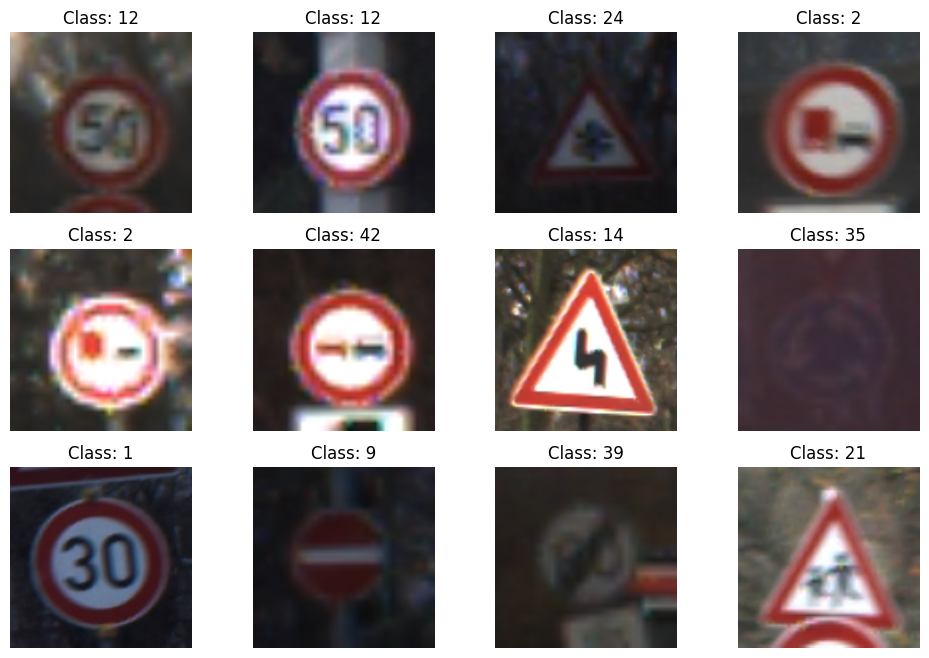

In [52]:
# Function to show images
def imshow(img):
    # Unnormalize the image
    img = img / 2 + 0.5  # Undo normalization
    img = img.numpy()  # Convert to numpy array
    plt.imshow(np.transpose(img, (1, 2, 0)))  # Convert to HWC format
    plt.axis('off')  # Hide axis

# Get a few samples from the training dataset
dataiter = iter(train_dl)
images, labels = next(dataiter)

# Plot the images and their corresponding labels
plt.figure(figsize=(12, 8))
num_images = 12
for i in range(num_images):
    plt.subplot(3, 4, i + 1)
    imshow(images[i])
    plt.title(f'Class: {labels[i].item()}')
    plt.axis('off')

plt.show()